# **UAV_IR_Surveillance**: Train example



```
# TODO list:
  * Implementar gen_movie(), tanto para revisar el data como para inferencia.
    ¿Podré usar los DataLoaders para aligerar la generación de las imágenes
    para el vídeo?
  * Generar una versión destilada de TrainSim con los vídeos más interesantes.
    30 GB es demasiado, el modelo no necesita todas esas imágenes.
```



Notebook muy sencillito para mostrar cómo hemos construido y entrenado a la red.

In [1]:
###################################################
# IMPORTANTE: Instalar la base de datos siguiendo #
# las instrucciones del README e indicar en estas #
# dos variables los direcctorios!!                #
TRAIN_DATA_PATH = "D:\Datos\TrainSimulation"
TEST_DATA_PATH  = "D:\Datos\TestReal"
###################################################

## Inicialización (COLAB)

In [1]:
# #####################################################
# # Si se ejecuta desde colab, descomentar esta celda #
# #####################################################

# ## Para descargar el proyecto e importar todas las dependencias
# !git clone https://github.com/jesusBV20/UAV_IR_Surveillance.git
# !mv UAV_IR_Surveillance/* . 
# !rm -r UAV_IR_Surveillance

Cloning into 'UAV_IR_Surveillance'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 106 (delta 41), reused 76 (delta 19), pack-reused 0
Receiving objects: 100% (106/106), 814.10 KiB | 21.42 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [2]:
# #####################################################
# # Si se ejecuta desde colab, descomentar esta celda #
# #####################################################

# ## ¿Qué GPU nos ha asignado google?
# !nvidia-smi

# ## Visualizamos la lista de procesos corriendo en GPU
# !sudo fuser -v /dev/nvidia*

# ## Matamos aquellos procesos zombie que nos están consumiendo memoria de GPU
# #!sudo kill -9 147

Wed Apr  5 18:50:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# #####################################################
# # Si se ejecuta desde colab, descomentar esta celda #
# #####################################################

# ## Para descargar y descomprimir los datos de forma automática --
# from IPython.display import clear_output

# # TrainReal
# !wget "https://storage.googleapis.com/public-datasets-lila/conservationdrones/v01/conservation_drones_train_real.zip"
# !unzip conservation_drones_train_real.zip
# clear_output()

# # TestReal
# !wget "https://storage.googleapis.com/public-datasets-lila/conservationdrones/v01/conservation_drones_test_real.zip"
# !unzip conservation_drones_test_real.zip
# clear_output()

# print("Done!")

Done!


## Librerías, clases y funciones externas

In [6]:
print(torch.__version__)

2.0.0+cpu


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from UAVIR_tools import BIRDSAIDataset, imgBoxes

WEIGHTS = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

# Si se encuentra disponible, seleccionamos GPU como dispositivo para entrenar
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device: {}\n".format(device))

"""
Función que toma Faster-RCNN pre-entrenado y genera un nuevo modelo
aplicando un fine-tunning en el clasificador, adaptándolo al número
de clases, que debe de ser indicado en 'num_classes'. 
"""
def get_tunned_model(num_classes):
  # Cargamos el modelo pre-entrenado
  model = fasterrcnn_resnet50_fpn(weights=WEIGHTS)

  # Reemplazamos el clasificador de la red
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

"""
Función que nos retorna las transformaciones necesarias para codificar las
imágenes (en formato PIL), de tal forma que sean interpretables por la red.
"""
def get_transform():
  return WEIGHTS.transforms() # __call__(<PIL image>)

Device: cpu



## Revisamos algunas imágenes del dataset

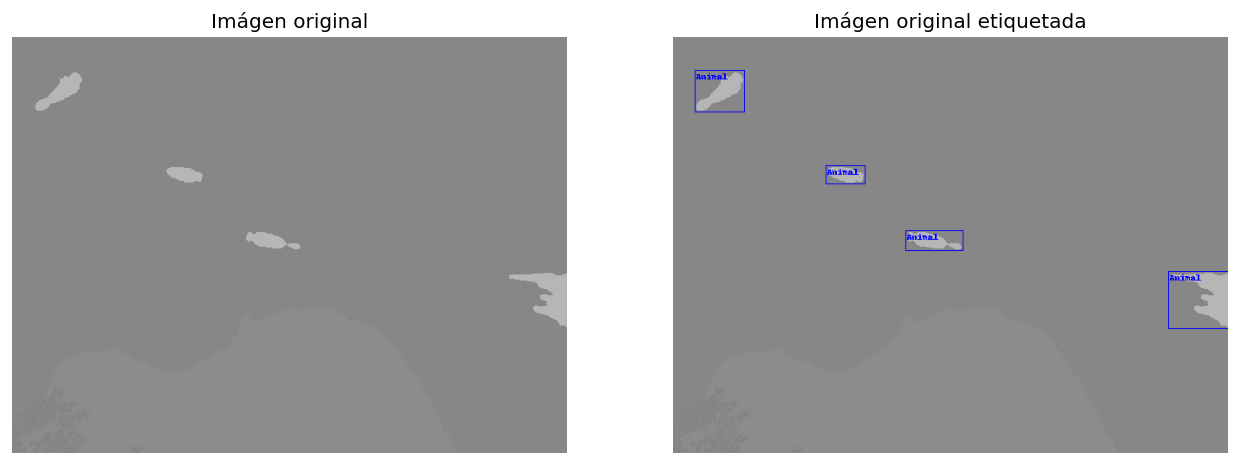

In [7]:
from torchvision import transforms as T

# Seleccionamos el vídeo y el frame
movie_id = 10
frame = 70

dataset = BIRDSAIDataset(TRAIN_DATA_PATH)
frame_init, frame_end, n_frames = dataset.getMovieBoxInfo(movie_id)

# Recogemos la img del dataset
img, target = dataset[frame_init + frame]

# Mostramos el resultado
FIGSIZE = [16, 9/2]
RES = 1920 # Full HD

img_box_real = imgBoxes(img, target["boxes"], target["labels"])

fig = plt.figure(figsize=FIGSIZE, dpi=RES/FIGSIZE[0])
ax1, ax2 = fig.subplots(1,2)
plt.subplots_adjust(wspace=-0.2)

ax1.axis('off')
ax2.axis("off")

ax1.set_title("Imágen original")
ax2.set_title("Imágen original etiquetada")

ax1.imshow(img)
ax2.imshow(img_box_real)
plt.show()

## Comprobamos que podemos inferir sobre la red sin entrenar

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\rema0/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:25<00:00, 6.70MB/s] 


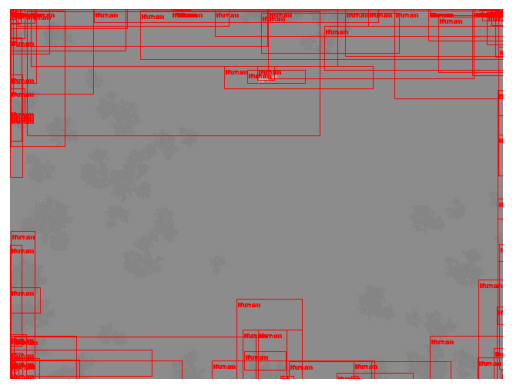

In [11]:
# Testeamos el tunned_model no entrenado
transforms = get_transform()

dataset = BIRDSAIDataset(TRAIN_DATA_PATH)
img, _ = dataset[0]
images = [transforms(d) for d in [img]]

model = get_tunned_model(3)
model_eval = model.eval()
outputs = model_eval(images)

# Mostramos el resultado
img_box = imgBoxes(img, outputs[0]["boxes"], outputs[0]["labels"])

fig = plt.figure()
ax = fig.add_subplot()
ax.axis('off')

ax.imshow(img_box)
plt.show()

## Entrenamos el modelo

In [ ]:
import torch
import torchvision

from UAVIR_tools.detection.engine import train_one_epoch, evaluate
import UAVIR_tools.detection.utils as utils

# ------- MAIN --------- #
# Nuestro dataset tiene tres calses: 2 human, 1 animal, 0 background
num_classes = 3

# Definimos los dataset de train y test
dataset = BIRDSAIDataset(TRAIN_DATA_PATH, get_transform())
dataset_test = BIRDSAIDataset(TEST_DATA_PATH, get_transform())

# Generemos unos nuevos datasets basados en los originales, pero más pequeños
indices = torch.randperm(len(dataset)).tolist() # suffle de las imágenes
dataset = torch.utils.data.Subset(dataset, indices[0:4000])
dataset_test = torch.utils.data.Subset(dataset_test, indices[0:100])

# Definimos los DataLoaders de entrenamiento y evaluación
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=4, shuffle=True, num_workers=4,
  collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test, batch_size=1, shuffle=False, num_workers=4,
  collate_fn=utils.collate_fn)

# Generamos el modelo utilizando la definida anteriormente
model = get_tunned_model(num_classes) 

# Guardamos el modelo en la RAM del dispositivo que estamos utilizando
model.to(device)

# Construimos un optimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# y un learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

## Entrenamos para 'num_epochs' épocas ########################################
num_epochs = 4

for epoch in range(num_epochs):
  # Ejecutanmos una época del entrenamiento, imprimiendo cada 10 iteraciones
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  # Actualizamos el learning rate
  lr_scheduler.step()

# ¡Guardamos el modelo entrenado!
torch.save(model.state_dict(), "model_AUVIR_test.pt")

## Comprobamos resultados realizando alguna inferencia

In [ ]:
OUTPUT_INFERENCE_PATH = "inference_output_imgs"

try:
  os.mkdir(OUTPUT_INFERENCE_PATH)
  print("¡Directorio '{}' creado!".format(OUTPUT_INFERENCE_PATH))
except:
  os.
  print("¡El directorio '{}' ya existe!".format(OUTPUT_INFERENCE_PATH))

In [ ]:
from torchvision import transforms as T

transforms = get_transform()

# Seleccionamos el vídeo y el frame
data_path = TEST_DATA_PATH
movie_id = 10
frame = 240

dataset = BIRDSAIDataset(data_path, transforms)
frame_init, frame_end, n_frames = dataset.getMovieBoxInfo(movie_id)

# Recogemos la img del dataset
img, target = dataset[frame_init + frame]
images = [img.to(device)]

# Cargamos el modelo entrenado
num_classes = 3
model = get_tunned_model(num_classes)

model.to(device)
model.load_state_dict(torch.load("model_AUVIR_test.pt"))

# Inferimos
model_eval = model.eval()
outputs = model_eval(images)

# Mostramos el resultado
FIGSIZE = [16, 9/2]
RES = 1920 # Full HD

transform_toImg = T.ToPILImage()
img = transform_toImg(img)

img_box_real = imgBoxes(img, target["boxes"], target["labels"])
img_box = imgBoxes(img, outputs[0]["boxes"], outputs[0]["labels"])

fig = plt.figure(figsize=FIGSIZE, dpi=RES/FIGSIZE[0])
ax1, ax2, ax3 = fig.subplots(1,3)
plt.subplots_adjust(wspace=0.01)

ax1.axis('off')
ax2.axis("off")
ax3.axis("off")

ax1.set_title("Imágen original")
ax2.set_title("Imágen original etiquetada")
ax3.set_title("Inferencia")

ax1.imshow(img)
ax2.imshow(img_box_real)
ax3.imshow(img_box)

plt.savefig(os.path.join(OUTPUT_INFERENCE_PATH, 
                         "{}-{}_{}.png".format(data_path,
                                               str(movie_id).zfill(4), 
                                               str(frame).zfill(5)) ),
            bbox_inches='tight', pad_inches = 0)
plt.show()

In [ ]:
#######################################################################
# Comprimimos todas las salidas para poder descargarlas con facilidad #
#######################################################################

!zip -r inference_output_imgs.zip inference_output_imgs

updating: inference_output_imgs/ (stored 0%)
updating: inference_output_imgs/TestReal-0010_00240.png (deflated 5%)
updating: inference_output_imgs/TrainReal-0001_00040.png (deflated 4%)
updating: inference_output_imgs/TrainReal-0007_00045.png (deflated 4%)
updating: inference_output_imgs/TrainReal-0021_00070.png (deflated 5%)
updating: inference_output_imgs/TestReal-0010_00130.png (deflated 5%)
updating: inference_output_imgs/TrainReal-0004_00040.png (deflated 6%)
updating: inference_output_imgs/TestReal-0010_00100.png (deflated 4%)
  adding: inference_output_imgs/.ipynb_checkpoints/ (stored 0%)
